In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

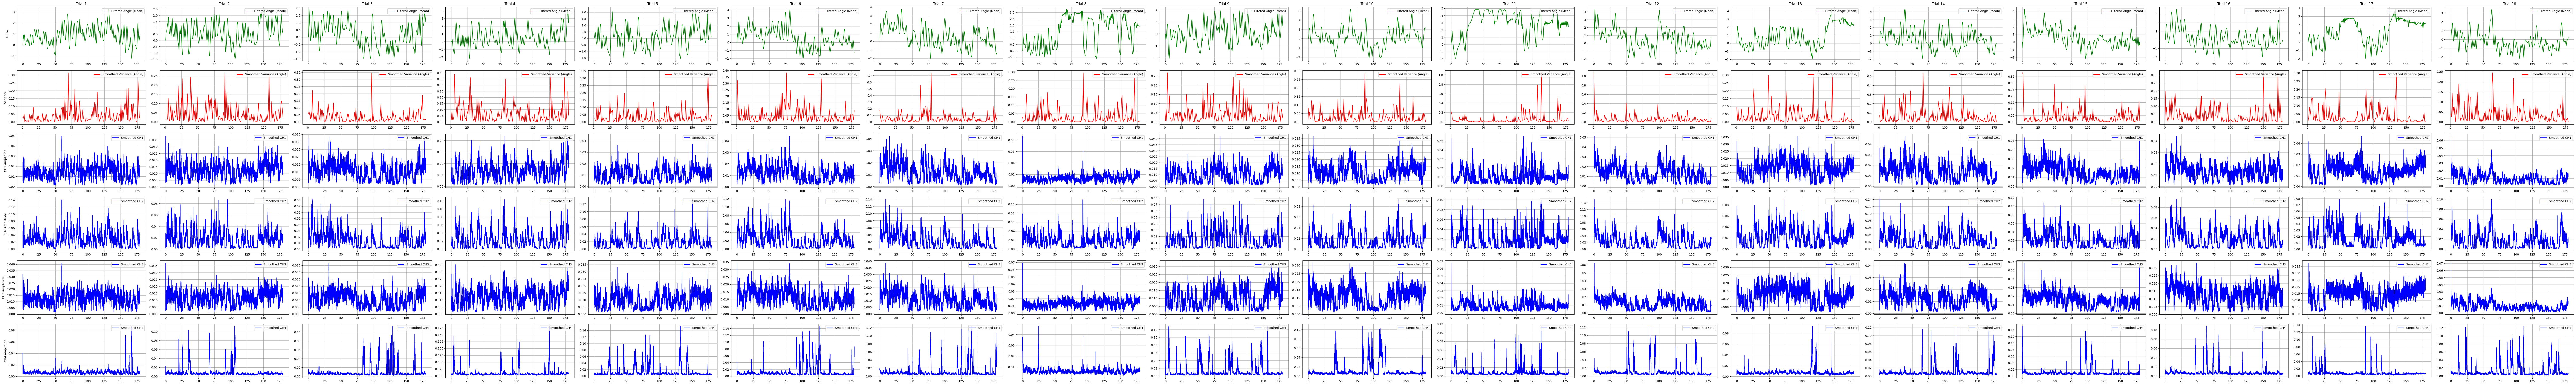

In [5]:
# Function to process and smooth each EMG channel
def process_channel(emg, Fs_emg):
    # Step 1: Remove Offset
    offset = np.mean(emg)
    emg_off = emg - offset

    # Step 2: Filtering (Bandstop + Bandpass)
    b0, a0 = butter(2, [59, 61], btype='bandstop', fs=Fs_emg)  # 60 Hz notch filter
    b, a = butter(2, [30, 450], btype='bandpass', fs=Fs_emg)   # Bandpass filter

    # Apply filtering
    emg_filt_stop = filtfilt(b0, a0, emg_off)
    emg_filt_pass = filtfilt(b, a, emg_filt_stop)

    # Step 3: Rectification
    emg_rect = np.abs(emg_filt_pass)

    # Step 4: Smoothing (Moving Average)
    window_size = 200  # Adjust based on desired window size
    emg_smooth = np.convolve(emg_rect, np.ones(window_size) / window_size, mode='valid')

    return emg_smooth

# Function to process robot data for a given trial
def process_robot_data(trial_num):
    robot_file = f'../data/pilot3/data/robot/trial{trial_num}_cleaned.csv'
    robot = pd.read_csv(robot_file, header=None)
    angle = pd.to_numeric(robot.iloc[:, 0], errors='coerce').fillna(0)
    
    # Sampling frequency for robot data (adjust if different)
    Fs_robot = 500  # Hz
    
    # Step 1: Apply a 10Hz low-pass filter to smooth the angle mean
    b_mean, a_mean = butter(2, 10, btype='low', fs=Fs_robot)
    angle_filtered = filtfilt(b_mean, a_mean, angle)
    
    # Step 2: Smooth the variance using a 1-second window
    window_size_var = int(Fs_robot * 1)  # 1-second window
    rolling_var = angle.rolling(window=window_size_var, center=True).var()
    
    # Optional: Downsample the variance if needed (e.g., every 1 second)
    step_size_var = window_size_var  # Moving the window every 1 second
    downsampled_var = rolling_var.iloc[::step_size_var].dropna()
    
    # Time vectors
    time_angle = np.arange(len(angle_filtered)) / Fs_robot
    time_var = downsampled_var.index / Fs_robot
    
    return angle_filtered, downsampled_var, time_angle, time_var

# Function to process EMG data for a given trial
def process_emg_data(trial_num, Fs_emg, selected_channels):
    emg_file = f'../data/pilot3/data/EMG/trial{trial_num}_cleaned.csv'
    data = pd.read_csv(emg_file)
    data = data[selected_channels]

    # Change NaNs to 0
    data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

    smoothed_signals = [process_channel(data[ch].values, Fs_emg) for ch in selected_channels]
    time_emg = np.linspace(0, len(smoothed_signals[0]) / Fs_emg, len(smoothed_signals[0]))
    return smoothed_signals, time_emg

# Main plotting code
Fs_emg = 2000
selected_channels = ["CH1", "CH2", "CH3", "CH4"]  # Channels: Soleus, Gastrocnemius Medialis, Gastrocnemius Lateralis, Tibialis Anterior

# Create the plot with 6 rows and 8 columns
fig, axs = plt.subplots(6, 18, figsize=(120, 18), sharex=False)

for trial_num in range(1, 19):
    # Process robot data
    angle_filtered, downsampled_var, time_angle, time_var = process_robot_data(trial_num)
    
    # Process EMG data (unchanged)
    smoothed_signals, time_emg = process_emg_data(trial_num, Fs_emg, selected_channels)
    
    # Plot the filtered angle mean
    axs[0, trial_num - 1].plot(time_angle, angle_filtered, label='Filtered Angle (Mean)', color='g')
    if trial_num == 1:
        axs[0, trial_num - 1].set_ylabel('Angle')
    axs[0, trial_num - 1].legend(loc='upper right')
    axs[0, trial_num - 1].grid(True)
    
    # Plot the smoothed variance
    axs[1, trial_num - 1].plot(time_var, downsampled_var, label='Smoothed Variance (Angle)', color='r')
    if trial_num == 1:
        axs[1, trial_num - 1].set_ylabel('Variance')
    axs[1, trial_num - 1].legend(loc='upper right')
    axs[1, trial_num - 1].grid(True)
    
    # Plot the EMG signals in the remaining subplots (unchanged)
    for i in range(4):
        ax = axs[i + 2, trial_num - 1]
        ax.plot(time_emg, smoothed_signals[i], label=f'Smoothed {selected_channels[i]}', color='b')
        if trial_num == 1:
            ax.set_ylabel(f'{selected_channels[i]} Amplitude')
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Set titles for each trial column
    axs[0, trial_num - 1].set_title(f'Trial {trial_num}')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Function to process and smooth each EMG channel
def process_channel(emg, Fs_emg):
    # Step 1: Remove Offset
    offset = np.mean(emg)
    emg_off = emg - offset

    # Step 2: Filtering (Bandstop + Bandpass)
    b0, a0 = butter(2, [59, 61], btype='bandstop', fs=Fs_emg)  # 60 Hz notch filter
    b, a = butter(2, [30, 450], btype='bandpass', fs=Fs_emg)   # Bandpass filter

    # Apply filtering
    emg_filt_stop = filtfilt(b0, a0, emg_off)
    emg_filt_pass = filtfilt(b, a, emg_filt_stop)

    # Step 3: Rectification
    emg_rect = np.abs(emg_filt_pass)

    # Step 4: Smoothing (Moving Average)
    window_size = 200  # Adjust based on desired window size
    emg_smooth = np.convolve(emg_rect, np.ones(window_size) / window_size, mode='valid')

    return emg_smooth

# Function to process robot data for a given trial
def process_robot_data(trial_num):
    robot_file = f'../data/pilot2/data/robot/trial{trial_num}_cleaned.csv'
    robot = pd.read_csv(robot_file, header=None)
    angle = pd.to_numeric(robot.iloc[:, 0], errors='coerce').fillna(0)
    
    # Sampling frequency for robot data (adjust if different)
    Fs_robot = 500  # Hz
    
    # Step 1: Apply a 10Hz low-pass filter to smooth the angle mean
    b_mean, a_mean = butter(2, 10, btype='low', fs=Fs_robot)
    angle_filtered = filtfilt(b_mean, a_mean, angle)
    
    # Step 2: Smooth the variance using a 1-second window
    window_size_var = int(Fs_robot * 1)  # 1-second window
    rolling_var = angle.rolling(window=window_size_var, center=True).var()
    
    # Optional: Downsample the variance if needed (e.g., every 1 second)
    step_size_var = window_size_var  # Moving the window every 1 second
    downsampled_var = rolling_var.iloc[::step_size_var].dropna()
    
    # Time vectors
    time_angle = np.arange(len(angle_filtered)) / Fs_robot
    time_var = downsampled_var.index / Fs_robot
    
    return angle_filtered, downsampled_var, time_angle, time_var

# Function to process EMG data for a given trial
def process_emg_data(trial_num, Fs_emg, selected_channels):
    emg_file = f'../data/pilot2/data/EMG/trial{trial_num}_cleaned.csv'
    data = pd.read_csv(emg_file)
    # emg_file = f'../data/pilot2/data/EMG/trial{trial_num}.txt'
    # data = pd.read_csv(emg_file, delimiter='\t', header=None)
    # Manually assign column names
    # columns = ["CH0", "CH1", "CH2", "CH3", "CH4", "CH5", "trg", "sine"]
    # data.columns = columns
    data = data[selected_channels]

    # Change NaNs to 0
    data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

    smoothed_signals = [process_channel(data[ch].values, Fs_emg) for ch in selected_channels]
    time_emg = np.linspace(0, len(smoothed_signals[0]) / Fs_emg, len(smoothed_signals[0]))
    return smoothed_signals, time_emg

# Main plotting code
Fs_emg = 2000
selected_channels = ["CH1", "CH2", "CH3", "CH4"]  # Channels: Soleus, Gastrocnemius Medialis, Gastrocnemius Lateralis, Tibialis Anterior

# Create the plot with 6 rows and 8 columns
fig, axs = plt.subplots(6, 8, figsize=(120, 18), sharex=False)

for trial_num in range(1, 9):
    # Process robot data
    angle_filtered, downsampled_var, time_angle, time_var = process_robot_data(trial_num)
    
    # Process EMG data (unchanged)
    smoothed_signals, time_emg = process_emg_data(trial_num, Fs_emg, selected_channels)
    
    # Plot the filtered angle mean
    axs[0, trial_num - 1].plot(time_angle, angle_filtered, label='Filtered Angle (Mean)', color='g')
    if trial_num == 1:
        axs[0, trial_num - 1].set_ylabel('Angle')
    axs[0, trial_num - 1].legend(loc='upper right')
    axs[0, trial_num - 1].grid(True)
    
    # Plot the smoothed variance
    axs[1, trial_num - 1].plot(time_var, downsampled_var, label='Smoothed Variance (Angle)', color='r')
    if trial_num == 1:
        axs[1, trial_num - 1].set_ylabel('Variance')
    axs[1, trial_num - 1].legend(loc='upper right')
    axs[1, trial_num - 1].grid(True)
    
    # Plot the EMG signals in the remaining subplots (unchanged)
    for i in range(4):
        ax = axs[i + 2, trial_num - 1]
        ax.plot(time_emg, smoothed_signals[i], label=f'Smoothed {selected_channels[i]}', color='b')
        if trial_num == 1:
            ax.set_ylabel(f'{selected_channels[i]} Amplitude')
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Set titles for each trial column
    axs[0, trial_num - 1].set_title(f'Trial {trial_num}')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
time_angle = np.linspace(0, len(rolling_mean)/500, len(rolling_mean))
time_emg = np.linspace(0, len(smoothed_signals[0]) / Fs_emg, len(smoothed_signals[0]))

# Create the plot with separate subplots for EMG, rolling mean, and variance
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot the rolling mean
axs[0].plot(time_angle, rolling_mean, label='Rolling Mean (Angle)', color='g')
axs[0].set_ylabel('Mean')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plot the rolling variance
axs[1].plot(time_angle, rolling_var, label='Rolling Variance (Angle)', color='r')
axs[1].set_ylabel('Variance')
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Plot the EMG signals in the remaining subplots
for i, ax in enumerate(axs[2:]):
    ax.plot(time_emg, smoothed_signals[i], label=f'Smoothed {selected_channels[i]}', color='b')
    ax.set_ylabel(f'{selected_channels[i]} Amplitude')
    ax.legend(loc='upper right')
    ax.grid(True)

# Final plot adjustments
plt.xlabel('Time (s)')
plt.suptitle('EMG Signals and Angle Data (Mean and Variance)', fontsize=16)
plt.show()

In [24]:
# Create time vector (assuming all channels have the same length)
time = np.linspace(0, len(smoothed_signals[0]) / Fs, len(smoothed_signals[0]))

# Plotting the smoothed signals stacked on top of each other
fig, axs = plt.subplots(len(selected_channels), 1, figsize=(12, 8), sharex=True)

for i, ax in enumerate(axs):
    ax.plot(time, smoothed_signals[i], label=f'Smoothed {selected_channels[i]}', color='b')
    ax.set_ylabel(f'{selected_channels[i]} Amplitude')
    ax.legend(loc='upper right')
    ax.grid(True)

# Final plot adjustments
plt.xlabel('Time (s)')
plt.suptitle('Smoothed EMG Signals for CH1 to CH4', fontsize=16)
plt.show()

In [22]:
emg = data['CH1'].values  # Convert to a NumPy array
Fs = 2000  # Sampling frequency

In [18]:
# Step 1: Remove Offset
offset = np.mean(emg)  # Mean value of the signal
emg_off = emg - offset  # Remove the offset

# Step 2: Filtering (Bandstop + Bandpass)
b0, a0 = butter(2, [59, 61], btype='bandstop', fs=Fs)  # 60 Hz notch filter
b, a = butter(2, [30, 450], btype='bandpass', fs=Fs)   # Bandpass filter

# Apply filtering
emg_filt_stop = filtfilt(b0, a0, emg_off)
emg_filt_pass = filtfilt(b, a, emg_filt_stop)

# Step 3: Rectification
emg_rect = np.abs(emg_filt_pass)

# Step 4: Smoothing (Moving Average)
window_size = 200  # Adjust based on desired smoothing window (in samples)
emg_smooth = np.convolve(emg_rect, np.ones(window_size) / window_size, mode='valid')

In [23]:
emg

array([ 0.   ,  0.001, -0.001, ..., -0.009, -0.009, -0.008])

In [ ]:
# Step 5: Plotting the Smoothed EMG
time = np.linspace(0, len(emg_smooth) / Fs, len(emg_smooth))  # Create time vector

plt.figure(figsize=(10, 4))
plt.plot(time, emg_smooth, label='Smoothed EMG', color='b')
plt.xlabel('Time (s)')
plt.ylabel('EMG Amplitude')
plt.title('Smoothed EMG Signal')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Robot

FileNotFoundError: [Errno 2] No such file or directory: 'pilot3/data/robot/trial1_cleaned.csv'

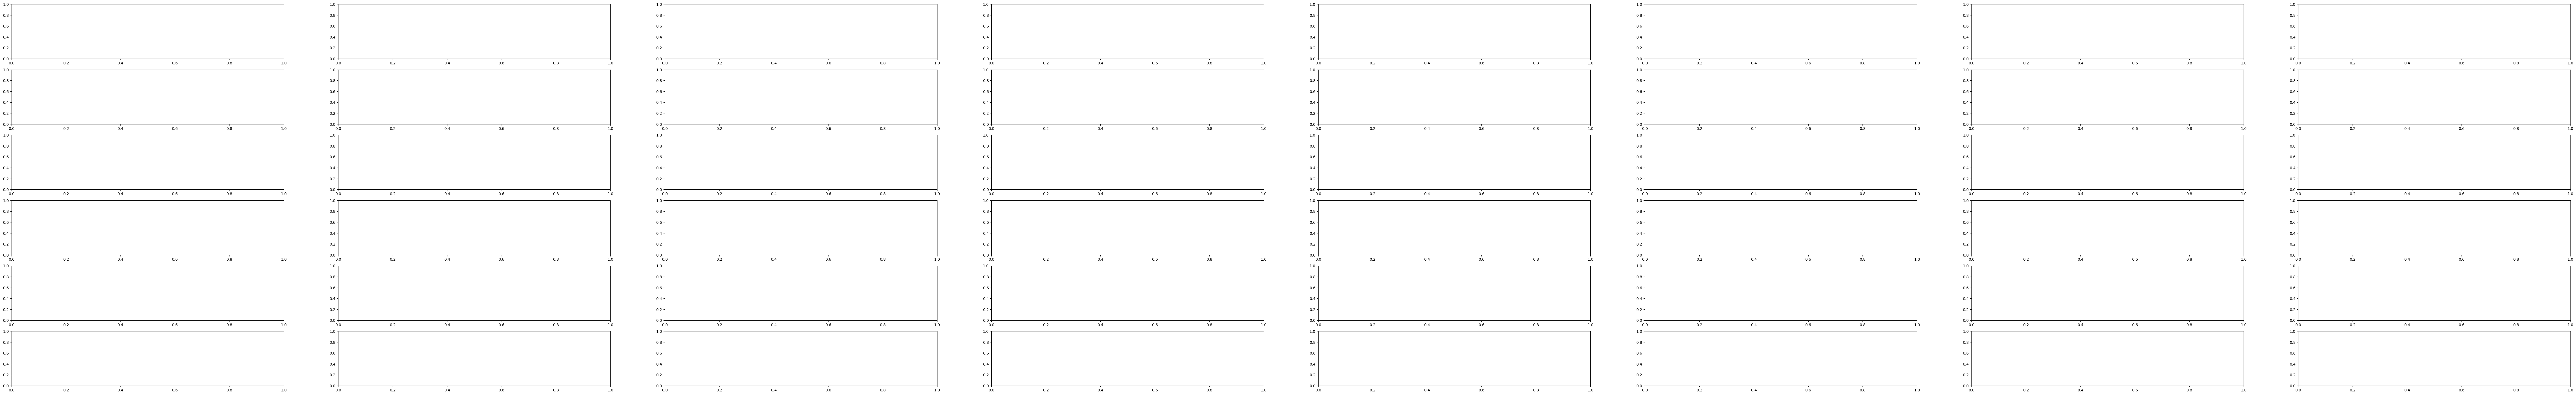

In [ ]:
# Function to process and smooth each EMG channel
def process_channel(emg, Fs_emg):
    # Step 1: Remove Offset
    offset = np.mean(emg)
    emg_off = emg - offset

    # Step 2: Filtering (Bandstop + Bandpass)
    b0, a0 = butter(2, [59, 61], btype='bandstop', fs=Fs_emg)  # 60 Hz notch filter
    b, a = butter(2, [30, 450], btype='bandpass', fs=Fs_emg)   # Bandpass filter

    # Apply filtering
    emg_filt_stop = filtfilt(b0, a0, emg_off)
    emg_filt_pass = filtfilt(b, a, emg_filt_stop)

    # Step 3: Rectification
    emg_rect = np.abs(emg_filt_pass)

    # Step 4: Smoothing (Moving Average)
    window_size = 200  # Adjust based on desired window size
    emg_smooth = np.convolve(emg_rect, np.ones(window_size) / window_size, mode='valid')

    return emg_smooth

# Function to process robot data for a given trial
def process_robot_data(trial_num):
    robot_file = f'pilot3/data/robot/trial{trial_num}_cleaned.csv'
    robot = pd.read_csv(robot_file, header=None)
    angle = pd.to_numeric(robot.iloc[:, 0], errors='coerce').fillna(0)
    # 30s windows and moving each second
    window_size = 15000 
    step_size = 500

    rolling_mean = angle.rolling(window=window_size, center=True).mean()
    rolling_var = angle.rolling(window=window_size, center=True).var()

    downsampled_mean = rolling_mean.iloc[::step_size].dropna()
    downsampled_var = rolling_var.iloc[::step_size].dropna()

    time_angle = np.linspace(0, len(downsampled_mean), len(downsampled_mean))
    return downsampled_mean, downsampled_var, time_angle

# Function to process EMG data for a given trial
def process_emg_data(trial_num, Fs_emg, selected_channels):
    emg_file = f'pilot3/data/EMG/trial{trial_num}.txt'
    data = pd.read_csv(emg_file, delimiter='\t', header=None)
    # Manually assign column names
    columns = ["CH0", "CH1", "CH2", "CH3", "CH4", "CH5", "trg", "sine"]
    data.columns = columns
    data = data[selected_channels]

    # Change NaNs to 0
    data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

    smoothed_signals = [process_channel(data[ch].values, Fs_emg) for ch in selected_channels]
    time_emg = np.linspace(0, len(smoothed_signals[0]) / Fs_emg, len(smoothed_signals[0]))
    return smoothed_signals, time_emg

# Main plotting code
Fs_emg = 2000
selected_channels = ["CH1", "CH2", "CH3", "CH4"]  # Channels: Soleus, Gastrocnemius Medialis, Gastrocnemius Lateralis, Tibialis Anterior

# Create the plot with 6 rows and 8 columns
fig, axs = plt.subplots(6, 8, figsize=(120, 18), sharex=False)

for trial_num in range(1, 9):
    # Process robot data
    downsampled_mean, downsampled_var, time_angle = process_robot_data(trial_num)

    # Process EMG data
    smoothed_signals, time_emg = process_emg_data(trial_num, Fs_emg, selected_channels)

    # Plot the rolling mean
    axs[0, trial_num - 1].plot(time_angle, downsampled_mean, label='Rolling Mean (Angle)', color='g')
    if trial_num == 1:
        axs[0, trial_num - 1].set_ylabel('Mean')
    axs[0, trial_num - 1].legend(loc='upper right')
    axs[0, trial_num - 1].grid(True)

    # Plot the rolling variance
    axs[1, trial_num - 1].plot(time_angle, downsampled_var, label='Rolling Variance (Angle)', color='r')
    if trial_num == 1:
        axs[1, trial_num - 1].set_ylabel('Variance')
    axs[1, trial_num - 1].legend(loc='upper right')
    axs[1, trial_num - 1].grid(True)

    # Plot the EMG signals in the remaining subplots
    for i in range(4):
        ax = axs[i + 2, trial_num - 1]
        ax.plot(time_emg, smoothed_signals[i], label=f'Smoothed {selected_channels[i]}', color='b')
        if trial_num == 1:
            ax.set_ylabel(f'{selected_channels[i]} Amplitude')
        ax.legend(loc='upper right')
        ax.grid(True)

    # Set titles for each trial column
    axs[0, trial_num - 1].set_title(f'Trial {trial_num}')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

/var/folders/pr/6yd68t_152nfdrf1v8m6vh7r0000gn/T/ipykernel_75499/1956285333.py:27: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  robot = pd.read_csv(robot_file, header=None)
/var/folders/pr/6yd68t_152nfdrf1v8m6vh7r0000gn/T/ipykernel_75499/1956285333.py:27: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  robot = pd.read_csv(robot_file, header=None)
/var/folders/pr/6yd68t_152nfdrf1v8m6vh7r0000gn/T/ipykernel_75499/1956285333.py:27: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  robot = pd.read_csv(robot_file, header=None)
/var/folders/pr/6yd68t_152nfdrf1v8m6vh7r0000gn/T/ipykernel_75499/1956285333.py:27: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  robot = pd.read_csv(robot_file, header=None)
/var/folders/pr/6yd68t_152nfdrf1v8m6vh7r0000gn/T/ipykern

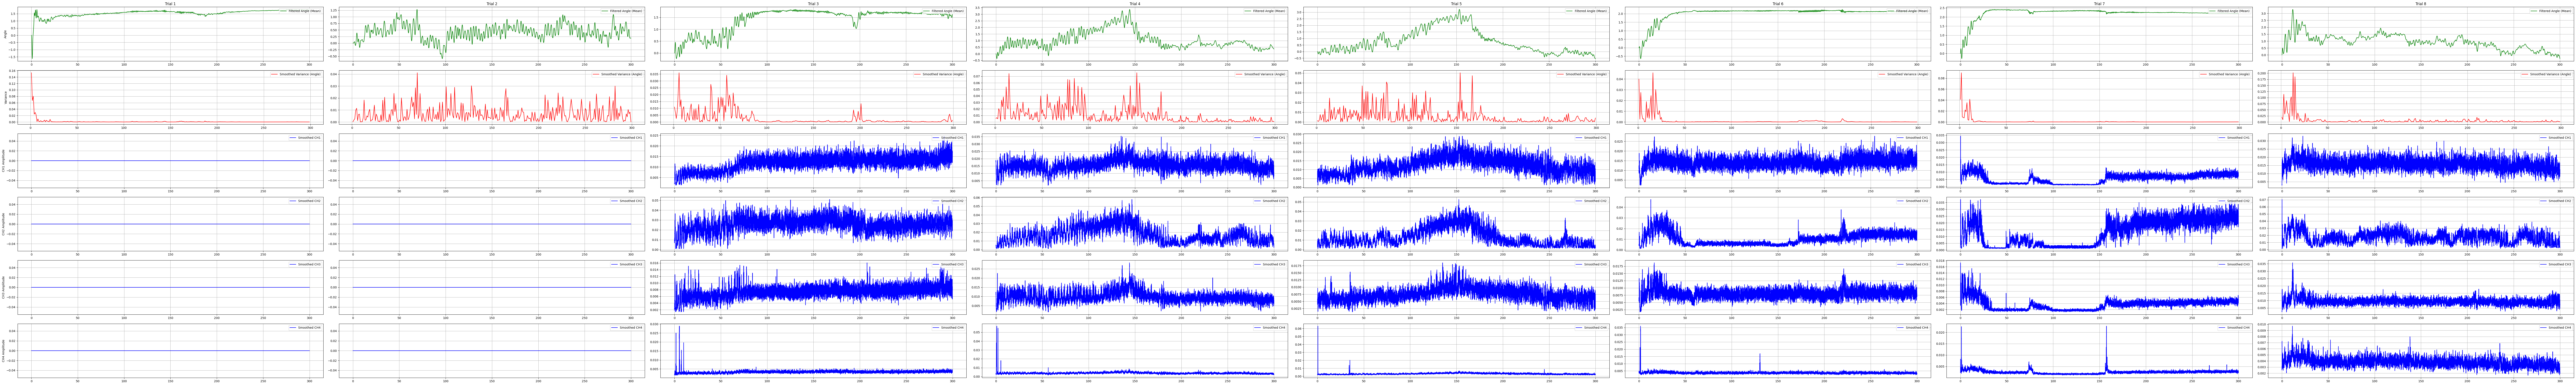

In [ ]:
# Function to process and smooth each EMG channel
def process_channel(emg, Fs_emg):
    # Step 1: Remove Offset
    offset = np.mean(emg)
    emg_off = emg - offset

    # Step 2: Filtering (Bandstop + Bandpass)
    b0, a0 = butter(2, [59, 61], btype='bandstop', fs=Fs_emg)  # 60 Hz notch filter
    b, a = butter(2, [30, 450], btype='bandpass', fs=Fs_emg)   # Bandpass filter

    # Apply filtering
    emg_filt_stop = filtfilt(b0, a0, emg_off)
    emg_filt_pass = filtfilt(b, a, emg_filt_stop)

    # Step 3: Rectification
    emg_rect = np.abs(emg_filt_pass)

    # Step 4: Smoothing (Moving Average)
    window_size = 200  # Adjust based on desired window size
    emg_smooth = np.convolve(emg_rect, np.ones(window_size) / window_size, mode='valid')

    return emg_smooth

# Function to process robot data for a given trial
def process_robot_data(trial_num):
    robot_file = f'../data/pilot2/data/robot/trial{trial_num}_cleaned.csv'
    robot = pd.read_csv(robot_file, header=None)
    angle = pd.to_numeric(robot.iloc[:, 0], errors='coerce').fillna(0)
    
    # Sampling frequency for robot data (adjust if different)
    Fs_robot = 500  # Hz
    
    # Step 1: Apply a 10Hz low-pass filter to smooth the angle mean
    b_mean, a_mean = butter(2, 10, btype='low', fs=Fs_robot)
    angle_filtered = filtfilt(b_mean, a_mean, angle)
    
    # Step 2: Smooth the variance using a 1-second window
    window_size_var = int(Fs_robot * 1)  # 1-second window
    rolling_var = angle.rolling(window=window_size_var, center=True).var()
    
    # Optional: Downsample the variance if needed (e.g., every 1 second)
    step_size_var = window_size_var  # Moving the window every 1 second
    downsampled_var = rolling_var.iloc[::step_size_var].dropna()
    
    # Time vectors
    time_angle = np.arange(len(angle_filtered)) / Fs_robot
    time_var = downsampled_var.index / Fs_robot
    
    return angle_filtered, downsampled_var, time_angle, time_var

# Function to process EMG data for a given trial
def process_emg_data(trial_num, Fs_emg, selected_channels):
    emg_file = f'../data/pilot2/data/EMG/trial{trial_num}_cleaned.csv'
    data = pd.read_csv(emg_file)
    # emg_file = f'../data/pilot2/data/EMG/trial{trial_num}.txt'
    # data = pd.read_csv(emg_file, delimiter='\t', header=None)
    # Manually assign column names
    # columns = ["CH0", "CH1", "CH2", "CH3", "CH4", "CH5", "trg", "sine"]
    # data.columns = columns
    data = data[selected_channels]

    # Change NaNs to 0
    data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

    smoothed_signals = [process_channel(data[ch].values, Fs_emg) for ch in selected_channels]
    time_emg = np.linspace(0, len(smoothed_signals[0]) / Fs_emg, len(smoothed_signals[0]))
    return smoothed_signals, time_emg

# Main plotting code
Fs_emg = 2000
selected_channels = ["CH1", "CH2", "CH3", "CH4"]  # Channels: Soleus, Gastrocnemius Medialis, Gastrocnemius Lateralis, Tibialis Anterior

# Create the plot with 6 rows and 8 columns
fig, axs = plt.subplots(6, 8, figsize=(120, 18), sharex=False)

for trial_num in range(1, 9):
    # Process robot data
    angle_filtered, downsampled_var, time_angle, time_var = process_robot_data(trial_num)
    
    # Process EMG data (unchanged)
    smoothed_signals, time_emg = process_emg_data(trial_num, Fs_emg, selected_channels)
    
    # Plot the filtered angle mean
    axs[0, trial_num - 1].plot(time_angle, angle_filtered, label='Filtered Angle (Mean)', color='g')
    if trial_num == 1:
        axs[0, trial_num - 1].set_ylabel('Angle')
    axs[0, trial_num - 1].legend(loc='upper right')
    axs[0, trial_num - 1].grid(True)
    
    # Plot the smoothed variance
    axs[1, trial_num - 1].plot(time_var, downsampled_var, label='Smoothed Variance (Angle)', color='r')
    if trial_num == 1:
        axs[1, trial_num - 1].set_ylabel('Variance')
    axs[1, trial_num - 1].legend(loc='upper right')
    axs[1, trial_num - 1].grid(True)
    
    # Plot the EMG signals in the remaining subplots (unchanged)
    for i in range(4):
        ax = axs[i + 2, trial_num - 1]
        ax.plot(time_emg, smoothed_signals[i], label=f'Smoothed {selected_channels[i]}', color='b')
        if trial_num == 1:
            ax.set_ylabel(f'{selected_channels[i]} Amplitude')
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Set titles for each trial column
    axs[0, trial_num - 1].set_title(f'Trial {trial_num}')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
robot = pd.read_csv('pilot3/data/robot/trial1_cleaned.csv', header = None)
angle = pd.to_numeric(robot.iloc[:, 0], errors='coerce').fillna(0)
# 30s windows and moving each second
window_size = 15000 
step_size = 500

rolling_mean = angle.rolling(window=window_size, center=True).mean()
rolling_var = angle.rolling(window=window_size, center=True).var()

downsampled_mean = rolling_mean.iloc[::step_size].dropna()
downsampled_var = rolling_var.iloc[::step_size].dropna()

/var/folders/pr/6yd68t_152nfdrf1v8m6vh7r0000gn/T/ipykernel_31769/3562241208.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  robot = pd.read_csv('Pilot1/data/robot/trial1_cleaned.csv', header = None)


#### EMG

In [ ]:
data = pd.read_csv('pilot3/data/EMG/trial1.txt', delimiter='\t', header = None)
# Manually assign column names
columns = ["CH0", "CH1", "CH2", "CH3", "CH4", "CH5", "trg", "sine"]
data.columns = columns
selected_channels = ["CH1", "CH2", "CH3", "CH4"] #1soleous, 2gas m, 3gas l, 4ta
data = data[selected_channels]

/var/folders/pr/6yd68t_152nfdrf1v8m6vh7r0000gn/T/ipykernel_31769/480193597.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Pilot1/data/EMG/trial1.txt', delimiter='\t', header = None)


In [ ]:
# change nan to 0
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)
Fs_emg = 2000

In [ ]:
Fs_emg = 2000
# Function to process and smooth each channel
def process_channel(emg):
    # Step 1: Remove Offset
    offset = np.mean(emg)
    emg_off = emg - offset

    # Step 2: Filtering (Bandstop + Bandpass)
    b0, a0 = butter(2, [59, 61], btype='bandstop', fs=Fs_emg)  # 60 Hz notch filter
    b, a = butter(2, [30, 450], btype='bandpass', fs=Fs_emg)   # Bandpass filter

    # Apply filtering
    emg_filt_stop = filtfilt(b0, a0, emg_off)
    emg_filt_pass = filtfilt(b, a, emg_filt_stop)

    # Step 3: Rectification
    emg_rect = np.abs(emg_filt_pass)

    # Step 4: Smoothing (Moving Average)
    window_size = 200  # Adjust based on desired window size
    emg_smooth = np.convolve(emg_rect, np.ones(window_size) / window_size, mode='valid')

    return emg_smooth

In [ ]:
# Process each selected channel (CH1 to CH4) and store the results
smoothed_signals = [process_channel(data[ch].values) for ch in selected_channels]

#### plot

In [ ]:
time_angle = np.linspace(0, len(downsampled_mean) + 30, len(downsampled_mean))
time_emg = np.linspace(0, len(smoothed_signals[0]) / Fs_emg, len(smoothed_signals[0]))

In [ ]:
# Create the plot with separate subplots for EMG, rolling mean, and variance
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot the rolling mean
axs[0].plot(time_angle, downsampled_mean, label='Rolling Mean (Angle)', color='g')
axs[0].set_ylabel('Mean')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plot the rolling variance
axs[1].plot(time_angle, downsampled_var, label='Rolling Variance (Angle)', color='r')
axs[1].set_ylabel('Variance')
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Plot the EMG signals in the remaining subplots
for i, ax in enumerate(axs[2:]):
    ax.plot(time_emg, smoothed_signals[i], label=f'Smoothed {selected_channels[i]}', color='b')
    ax.set_ylabel(f'{selected_channels[i]} Amplitude')
    ax.legend(loc='upper right')
    ax.grid(True)

# Final plot adjustments
plt.xlabel('Time (s)')
plt.suptitle('EMG Signals and Angle Data (Mean and Variance)', fontsize=16)
plt.show()

In [ ]:
# Function to process and smooth each channel
def process_channel(emg):
    # Step 1: Remove Offset
    offset = np.mean(emg)
    emg_off = emg - offset

    # Step 2: Filtering (Bandstop + Bandpass)
    b0, a0 = butter(2, [59, 61], btype='bandstop', fs=Fs_emg)  # 60 Hz notch filter
    b, a = butter(2, [30, 450], btype='bandpass', fs=Fs_emg)   # Bandpass filter

    # Apply filtering
    emg_filt_stop = filtfilt(b0, a0, emg_off)
    emg_filt_pass = filtfilt(b, a, emg_filt_stop)

    # Step 3: Rectification
    emg_rect = np.abs(emg_filt_pass)

    # Step 4: Smoothing (Moving Average)
    window_size = 200  # Adjust based on desired window size
    emg_smooth = np.convolve(emg_rect, np.ones(window_size) / window_size, mode='valid')

    return emg_smooth

In [ ]:
### robot
robot = pd.read_csv('Pilot1/data/robot/trial1_cleaned.csv', header = None)
angle = pd.to_numeric(robot.iloc[:, 0], errors='coerce').fillna(0)
# 30s windows and moving each second
window_size = 15000 
step_size = 500

rolling_mean = angle.rolling(window=window_size, center=True).mean()
rolling_var = angle.rolling(window=window_size, center=True).var()

downsampled_mean = rolling_mean.iloc[::step_size].dropna()
downsampled_var = rolling_var.iloc[::step_size].dropna()

### emg
data = pd.read_csv('Pilot1/data/EMG/trial1.txt', delimiter='\t', header = None)
# Manually assign column names
columns = ["CH0", "CH1", "CH2", "CH3", "CH4", "CH5", "trg", "sine"]
data.columns = columns
selected_channels = ["CH1", "CH2", "CH3", "CH4"] #1soleous, 2gas m, 3gas l, 4ta
data = data[selected_channels]

# change nan to 0
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)
Fs_emg = 2000
smoothed_signals = [process_channel(data[ch].values) for ch in selected_channels]

time_angle = np.linspace(0, len(downsampled_mean) + 30, len(downsampled_mean))
time_emg = np.linspace(0, len(smoothed_signals[0]) / Fs_emg, len(smoothed_signals[0]))

In [ ]:
# Create the plot with separate subplots for EMG, rolling mean, and variance
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot the rolling mean
axs[0].plot(time_angle, downsampled_mean, label='Rolling Mean (Angle)', color='g')
axs[0].set_ylabel('Mean')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plot the rolling variance
axs[1].plot(time_angle, downsampled_var, label='Rolling Variance (Angle)', color='r')
axs[1].set_ylabel('Variance')
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Plot the EMG signals in the remaining subplots
for i, ax in enumerate(axs[2:]):
    ax.plot(time_emg, smoothed_signals[i], label=f'Smoothed {selected_channels[i]}', color='b')
    ax.set_ylabel(f'{selected_channels[i]} Amplitude')
    ax.legend(loc='upper right')
    ax.grid(True)

# Final plot adjustments
plt.xlabel('Time (s)')
plt.suptitle('EMG Signals and Angle Data (Mean and Variance)', fontsize=16)
plt.show()